In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from ipywidgets import IntProgress
from IPython.display import display

In [2]:
contests = pd.read_csv('data/ContestsWithoutCheats.csv').set_index('ContestId').dropna()

In [3]:
def cutDF(df, intendedNumber):
    df = df.sample(frac=intendedNumber/len(df), replace=True)
    return df

In [4]:
def balanceDF(df, colName, numberOfEach = 0):
    successDF, failDF = df.loc[df[colName] == 1], df.loc[df[colName] == 0]
    if(numberOfEach == 0):
        maxContestsForBalance = min(len(successDF), len(failDF))
        numberOfEach = int(maxContestsForBalance*.1)
    combinedDF = pd.concat([cutDF(successDF, numberOfEach), cutDF(failDF, numberOfEach)])
    return combinedDF.sample(frac=1)

In [5]:
def spitTrainingTesting(df, percentTrain):
    df['is_train'] = np.random.uniform(0, 1, len(df)) <= percentTrain
    trainDF, testDF = df[df['is_train']==True], df[df['is_train']==False]
    df = df.drop(['is_train'], axis=1)
    trainDF = trainDF.drop(['is_train'], axis=1)
    testDF = testDF.drop(['is_train'], axis=1)
    return trainDF, testDF


In [6]:
classifiers = [RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier]
def getRandomClassifier(): 
    return classifiers[random.randint(0, len(classifiers)-1)]

In [7]:
def makeAndTrainClassifier(trainDF, classifierType): 
    clfFeatures = trainDF.columns.drop('Success')
    trainActual = trainDF['Success']
    clf = classifierType()
    clf.fit(trainDF[clfFeatures], trainActual)
    return clf

In [8]:
def classifierWrapper(trainDF, classifierType, balanced, numColumns = 0):
    #if numColumns is 0 or >#ofColumns, clf will train on all columns
    if(numColumns == 0  or numColumns > len(trainDF.columns)-1):
        numColumns = len(trainDF)
    columnDF = trainDF[trainDF.columns.drop('Success')].sample(numColumns, axis=1)
    columns  = pd.merge(trainDF[['Success']], columnDF, on='ContestId', how='left').columns
    if(balanced):
        trainDF = balanceDF(contests, 'Success')
    clf = makeAndTrainClassifier(trainDF[columns], classifierType)
    return clf, columns

In [44]:
def trainEnsemble(trainDF, numClassifiers = 100, classifierType = RandomForestClassifier, balanced = True):
    if classifierType == 'random':
        classifierType = getRandomClassifier()
    trainBar = IntProgress(min=0, max=numClassifiers, description='Training:')
    display(trainBar)
    clfs = []
    for c in range(0, numClassifiers):
        tDF = trainDF.copy()
        clf, cols = classifierWrapper(tDF, classifierType, balanced, numColumns=10)
        clfs.append({'clf': clf, 'cols':cols})
        trainBar.value += 1
    return clfs

In [45]:
def testEnsemble(testDF, ensemble):
    testBar = IntProgress(min=0, max=len(ensemble), description='Testing:')
    display(testBar)
    
    testActual = testDF['Success']
    clfFeatures = testDF[testDF.columns.drop('Success')]
    preds = []
    for clf in ensemble:
        preds.append(clf['clf'].predict(testDF[clf['cols'].drop('Success')]))
        testBar.value += 1
    return preds

In [19]:
def makeDiscrete(array):
    dArr = []
    for v in array:
        if(v < .5):
            dArr.append(0.)
        else:
            dArr.append(1.)
    return dArr

In [93]:
def makeEnsembleWithMinAcc(testDF, testActual, numClassifiers, minAcc):
    goodCLFs = []
    genBar = IntProgress(min=0, max=numClassifiers, description='Collecting Accurate CLFs:')
    display(genBar)
    for i in range(0, numClassifiers):
        acc = 0
        clf, cols = 'err', 'err'
        while acc < minAcc:
            clf, cols = classifierWrapper(trainDF, RandomForestClassifier, True, numColumns = random.randint(6, 20))
#             clf, cols = classifierWrapper(trainDF, getRandomClassifier(), True, numColumns = random.randint(6, 20))
            pred = clf.predict(testDF[cols.drop('Success')])
            acc = accuracy_score(testActual, pred)
        print(acc)
        goodCLFs.append({'clf': clf, 'cols':cols})
        genBar.value += 1
    return goodCLFs

In [94]:
df = contests.copy(deep=True)
trainDF, testDF = spitTrainingTesting(df, .8)
testActual = testDF.reset_index()['Success']
CLFs = makeEnsembleWithMinAcc(testDF, testActual, 10, .62)

IntProgress(value=0, description='Collecting Accurate CLFs:', max=10)

0.6460396039603961
0.6243408308222127
0.6302329961256995
0.6398245802841154
0.6233588032716315
0.6244080929832113
0.6337575333620319
0.6279057253551442
0.6214754627636677
0.6230628497632372


In [97]:
preds = testEnsemble(testDF, CLFs)
numCLF = len(preds)
avgPreds = []
for y in range(0, len(preds[0])):
    predSum = 0
    for x in range(0, len(preds)):
        predSum += preds[x][y]
    avgPreds.append(predSum/numCLF)
print(accuracy_score(testActual, makeDiscrete(avgPreds)))
print(confusion_matrix(testActual, makeDiscrete(avgPreds)))

IntProgress(value=0, description='Testing:', max=10)

0.7745506887645286
[[ 2149  1156]
 [15603 55428]]


In [67]:
# Avg num columns
colCounts = {}
for c in CLFs:
    cols = c['cols'].drop('Success')
    for col in cols:
        if not(col in colCounts):
            colCounts[col] = 1
        else:
            colCounts[col] += 1

In [70]:
for col in colCounts:
    if colCounts[col] > 15:
        print(col, colCounts[col])

21_HoursOut 16
EntryFeeAmount_Scaled 22
VariantName_Tiers 16
Contest_Group_Satellite 19
SportName_TEN 16
DraftablePlayersInSet_Scaled 17
42_HoursOut 16
PaidUsersInDraftGroup_Scaled 25
Start_DayOfWeek_Y 19
SportName_NHL 19
Payout_Day_X 16


In [46]:
clfs = trainEnsemble(trainDF, numClassifiers = 100, classifierType = RandomForestClassifier, balanced = True)
preds = testEnsemble(testDF, clfs)

IntProgress(value=0, description='Training:')

IntProgress(value=0, description='Testing:')

In [54]:
accuracies = []
for pred in preds:
    accuracies.append(accuracy_score(testActual,pred))

In [62]:
max(accuracies)

0.7254667240544467

In [47]:
numCLF = len(preds)
avgPreds = []
for y in range(0, len(preds[0])):
    predSum = 0
    for x in range(0, len(preds)):
        predSum += preds[x][y]
    avgPreds.append(predSum/numCLF)

In [49]:
accuracy_score(testActual, makeDiscrete(avgPreds))

0.6646984451498359

In [41]:
confusion_matrix(testActual, makeDiscrete(avgPreds))

array([[ 2333,   935],
       [23994, 47086]])

In [42]:
import matplotlib.pyplot as plt

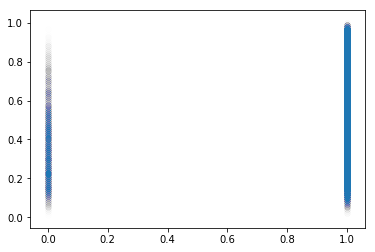

In [43]:
plt.scatter(testActual, avgPreds, alpha=.005)

### Required Accuracy:

In [18]:
numFail = len(contests.loc[contests['Success']==0])
print('Percent of contests that breakeven:', 1-numFail/len(contests))

Percent of contests that breakeven: 0.9557476004094012
